### SHRED with moving sensors applied to pressure/temperature/gas ARA dataset

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

With mobile sensors, the sensor itself is moving with the system dynamics, such that the sensor will be located in a different spatial location at each temporal snapshot.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/mebers/SHRED/SHRED_code/')
from executeMobileSHRED import mse_error

In [2]:
import imageio

def imageio2array(video_capture):
    
    # Open the video file
    video_reader = imageio.get_reader(video_capture)  # Replace 'your_video.mp4' with your file path

    # Initialize an empty list to store the frames
    frames = []

    # Read video frames and append them to the list
    for frame in video_reader:
        frames.append(frame)

    # Convert the list of frames to a 3D NumPy array
    video_array = np.array(frames)

    # Close the video file
    video_reader.close()

    # Convert the list of frames to a 3D NumPy array
    return video_array


# Open the video file on doppio


In [3]:

temperature_mp4 = '/home/mebers/SHRED/ARA/Detonation/ARA_Data/T.mp4'  
pressure_mp4 = '/home/mebers/SHRED/ARA/Detonation/ARA_Data/p.mp4'  
gas_mp4 = '/home/mebers/SHRED/ARA/Detonation/ARA_Data/alpha_gas.mp4'  # test.mp4 is the dataset given to me by Mike with a small time window but large temporal resolution

T_full = imageio2array(temperature_mp4)
p_full = imageio2array(pressure_mp4)
gas_full = imageio2array(gas_mp4)

#T = T[:,250:520,456:1149]
#p = p[:,250:520,456:1149]
#gas = gas[:,250:520,456:1149]

# Check the shape of the resulting array (height, width, frames)
print('Shape of temperature data: '+str(T_full.shape)) # [time, x, y, color]
print('Shape of pressure data: '+str(p_full.shape))
print('Shape of gas data: '+str(gas_full.shape))

# Now, video_array contains your video frames as a 3D NumPy array


Shape of temperature data: (101, 770, 1584, 3)
Shape of pressure data: (101, 770, 1584, 3)
Shape of gas data: (101, 770, 1584, 3)


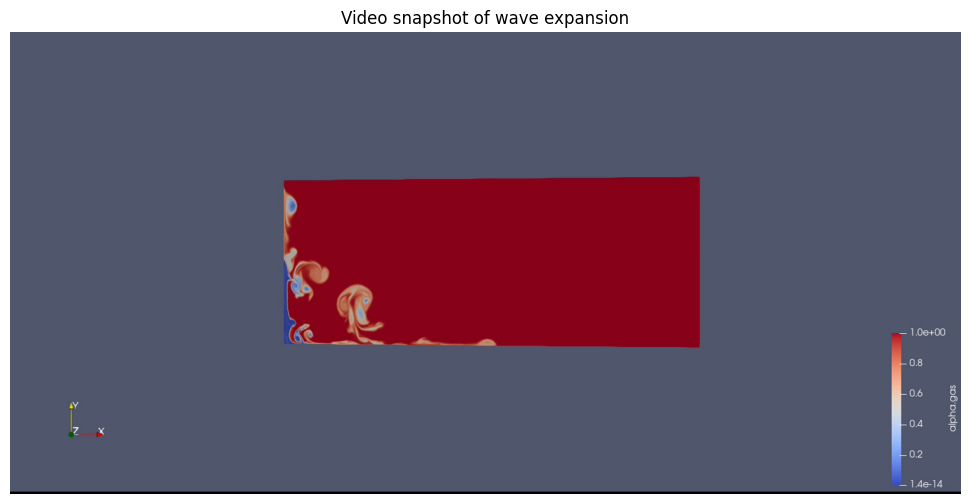

In [4]:
plt.figure(figsize=(20,6))
plt.imshow(gas_full[100,:,:])  #
plt.axis('off')  # Hide axes
plt.title('Video snapshot of wave expansion')
plt.show()

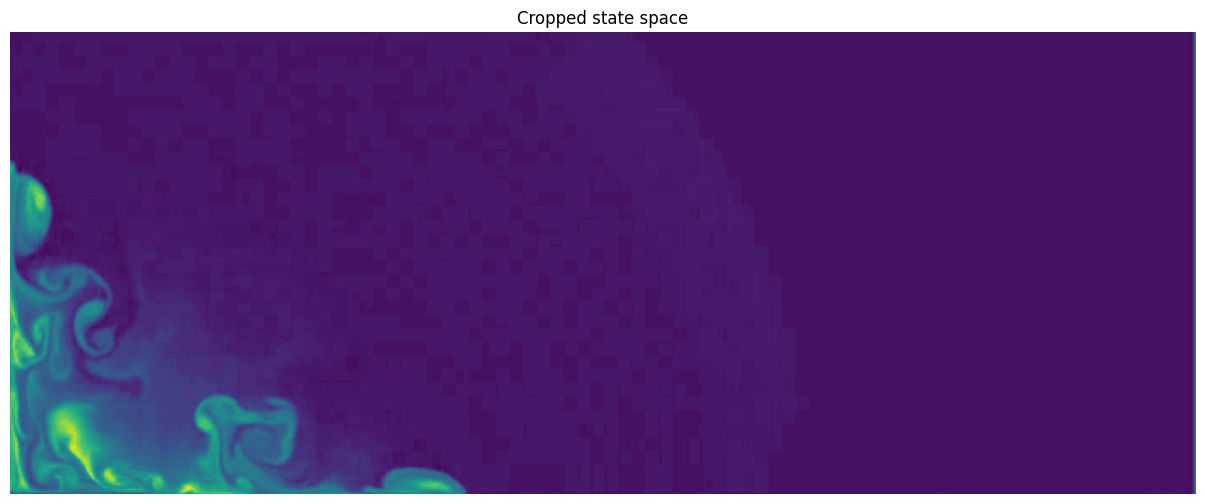

In [290]:
plt.figure(figsize=(20,6))
plt.imshow(T_full[50,251:521,457:1150,0])  #
plt.axis('off')  # Hide axes
plt.title('Cropped state space')
plt.show()

In [291]:
# just chose the first RBG signal
gas = gas_full[:,251:521,457:1150,0]
T = T_full[:,251:521,457:1150,0]
p = p_full[:,251:521,457:1150,0]

print(gas.shape)

(101, 270, 693)


In [391]:
lags = 25
load_X = p
t = load_X.shape[0]
row = load_X.shape[1]
col = load_X.shape[2]
signals = 1#load_X.shape[3]

num_sensors = int(signals)

print(load_X.shape)

(101, 270, 693)


# Prepare data for SHRED

In [392]:
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
from sklearn.preprocessing import MinMaxScaler

In [393]:
def calc_MSE(test_recons, test_ground_truth):
    MSE_err = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)

    return MSE_err

### Choose input field

In [394]:
data_name = 'pressure' 

if data_name == 'temperature':
    data_field = T
elif data_name == 'pressure':
    data_field = p
elif data_name == 'concentration':
    data_field = gas

load_X_flat = np.reshape(data_field, (t, row*col, signals))
print(load_X_flat.shape)

(101, 187110, 1)


In [395]:
out_X_flat=np.concatenate([np.reshape(gas, (t, row*col, signals)), np.reshape(T, (t, row*col, signals)), np.reshape(p, (t, row*col, signals))], axis=1)
print(out_X_flat.shape)

(101, 561330, 1)


We also create a trajectory that contains the single mobile sensor locations over time

In [396]:
def generate_scaled_circle_trajectory(length, min_value, max_value):
    """
    Generate a scaled circle trajectory with a specified length, scaled between min_value and max_value.

    Args:
    - length: The desired length of the trajectory (number of points).
    - min_value: The minimum value for scaling (e.g., -1).
    - max_value: The maximum value for scaling (e.g., 1).

    Returns:
    - x_scaled: Scaled x-coordinates of the trajectory.
    - y_scaled: Scaled y-coordinates of the trajectory.
    """
    # Number of points in the trajectory
    num_points = length

    # Create an array of angles between 0 and 2*pi (full circle)
    angles = np.linspace(0, 2 * np.pi, num_points)

    # Radius of the circle
    radius = 1

    # Calculate the x and y coordinates of the circle
    x_coordinates = radius * np.cos(angles)
    y_coordinates = radius * np.sin(angles)

    # Scale and round the coordinates to the specified range
    x_scaled = np.round(((x_coordinates - x_coordinates.min()) / (x_coordinates.max() - x_coordinates.min()) * (max_value - min_value) + min_value)).astype(int)
    y_scaled = np.round(((y_coordinates - y_coordinates.min()) / (y_coordinates.max() - y_coordinates.min()) * (max_value - min_value) + min_value)).astype(int)

    return x_scaled, y_scaled



In [397]:
#drone = np.linspace(0+50,100+50, 101)

j = 110 # length of one circle indices
ind_x = 5 # defines distance from 0 of circle radius
ind_y = 90 # defines distance from circle radius

x_traj, y_traj = generate_scaled_circle_trajectory(j, ind_x, ind_y) 

# create tile of circle trajectory indices repeated over the total time 
x_traj_locations = np.tile(x_traj, (np.ceil(load_X.shape[0]/j)).astype(int))[:load_X.shape[0]]
y_traj_locations = np.tile(y_traj, (np.ceil(load_X.shape[0]/j)).astype(int))[:load_X.shape[0]]

x_unit = np.linspace(10, 250, j)
y_unit = np.linspace(50, 300, j)

print(x_traj_locations.shape)

(101,)


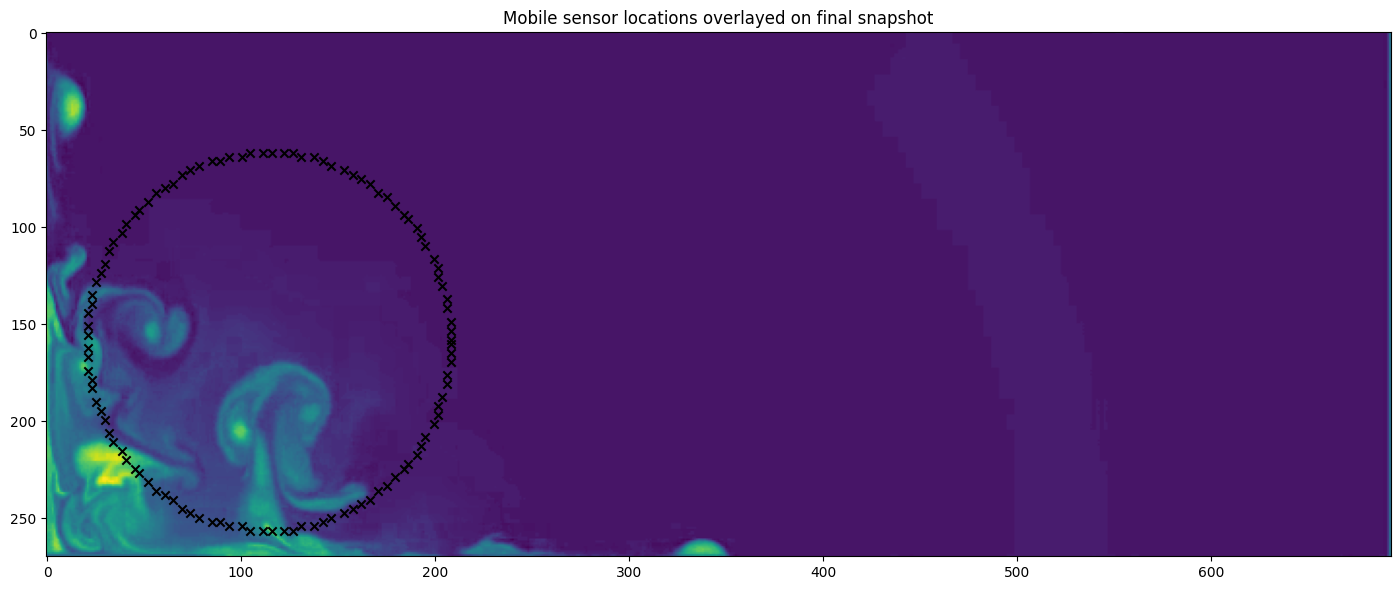

In [398]:
#-------------------------
# Create Animations/Plots
#-------------------------

plt.figure(figsize=(20,6))
plt.imshow(T[100,...])  #

#plt.scatter(5*np.ones(101), drone,c='black', marker='x')
plt.scatter(x_unit[x_traj], y_unit[y_traj] ,c='black', marker='x')
plt.title('Mobile sensor locations overlayed on final snapshot')

# Adjust spacing and display the subplot
plt.tight_layout()
plt.show()

We now select indices to divide the data into training, validation, and test sets.

In [399]:
train_indices = np.random.choice(t - lags, size=int(np.round(t*0.7)), replace=False)
mask = np.ones(t - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, t - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

print(train_indices.shape)

(71,)


In [400]:
load_X = np.reshape(load_X_flat, (t, -1))
print(load_X.shape)

out_X = np.reshape(out_X_flat, (t, -1))
print(out_X.shape)


(101, 187110)
(101, 561330)


sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [401]:
#sc = MinMaxScaler()
#sc = sc.fit(load_X[train_indices])
#transformed_X = sc.transform(load_X)

transformed_X = load_X
transformed_X.shape

(101, 187110)

## Find value at each of the x,y coordinates of the mobile sensor

In [402]:
X_input = np.zeros((len(x_traj_locations), signals))

# find the value at each x, y coord each snapshot in time
for k in range(signals): # 3 RBG "signals"
    for i in range(X_input.shape[0]): # each time snapshot
        X_input[i,k] = transformed_X.reshape(t,row,col,signals)[i][y_traj_locations[i]][x_traj_locations[i]][k]

### Time delay embed mobile sensor values

In [403]:
X_input.shape 
X_input_lag = np.zeros((t - lags, lags, num_sensors))

for i in range(len(X_input_lag)):
    X_input_lag[i] = X_input[i:i+lags, :]

print(X_input_lag.shape)

(76, 25, 1)


In [404]:
### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)
print()

train_data_in = torch.tensor(X_input_lag[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(X_input_lag[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(X_input_lag[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(out_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(out_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(out_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

Using device: cuda



In [405]:
import gc
torch.cuda.empty_cache()
gc.collect()

20508

We train the model using the training and validation datasets.

In [406]:
shred = models.SHRED(num_sensors, 3*row*col*signals, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=512, num_epochs=500, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.9999, device='cuda:0')
Training epoch 20
Error tensor(0.8123, device='cuda:0')
Training epoch 40
Error tensor(0.0857, device='cuda:0')
Training epoch 60
Error tensor(0.0880, device='cuda:0')
Training epoch 80
Error tensor(0.0669, device='cuda:0')
Training epoch 100
Error tensor(0.0586, device='cuda:0')
Training epoch 120
Error tensor(0.0584, device='cuda:0')
Training epoch 140
Error tensor(0.0581, device='cuda:0')
Training epoch 160
Error tensor(0.0582, device='cuda:0')
Training epoch 180
Error tensor(0.0587, device='cuda:0')
Training epoch 200
Error tensor(0.0581, device='cuda:0')
Training epoch 220
Error tensor(0.0582, device='cuda:0')
Training epoch 240
Error tensor(0.0583, device='cuda:0')


Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [407]:
#test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
#test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())

test_recons = shred(test_dataset.X).detach().cpu().numpy()
test_ground_truth = test_dataset.Y.detach().cpu().numpy()
err = calc_MSE(test_recons, test_ground_truth)
print(err)

0.05607965


In [408]:
np.reshape(test_recons, (-1, row, col, signals)).shape

(6, 270, 693, 1)

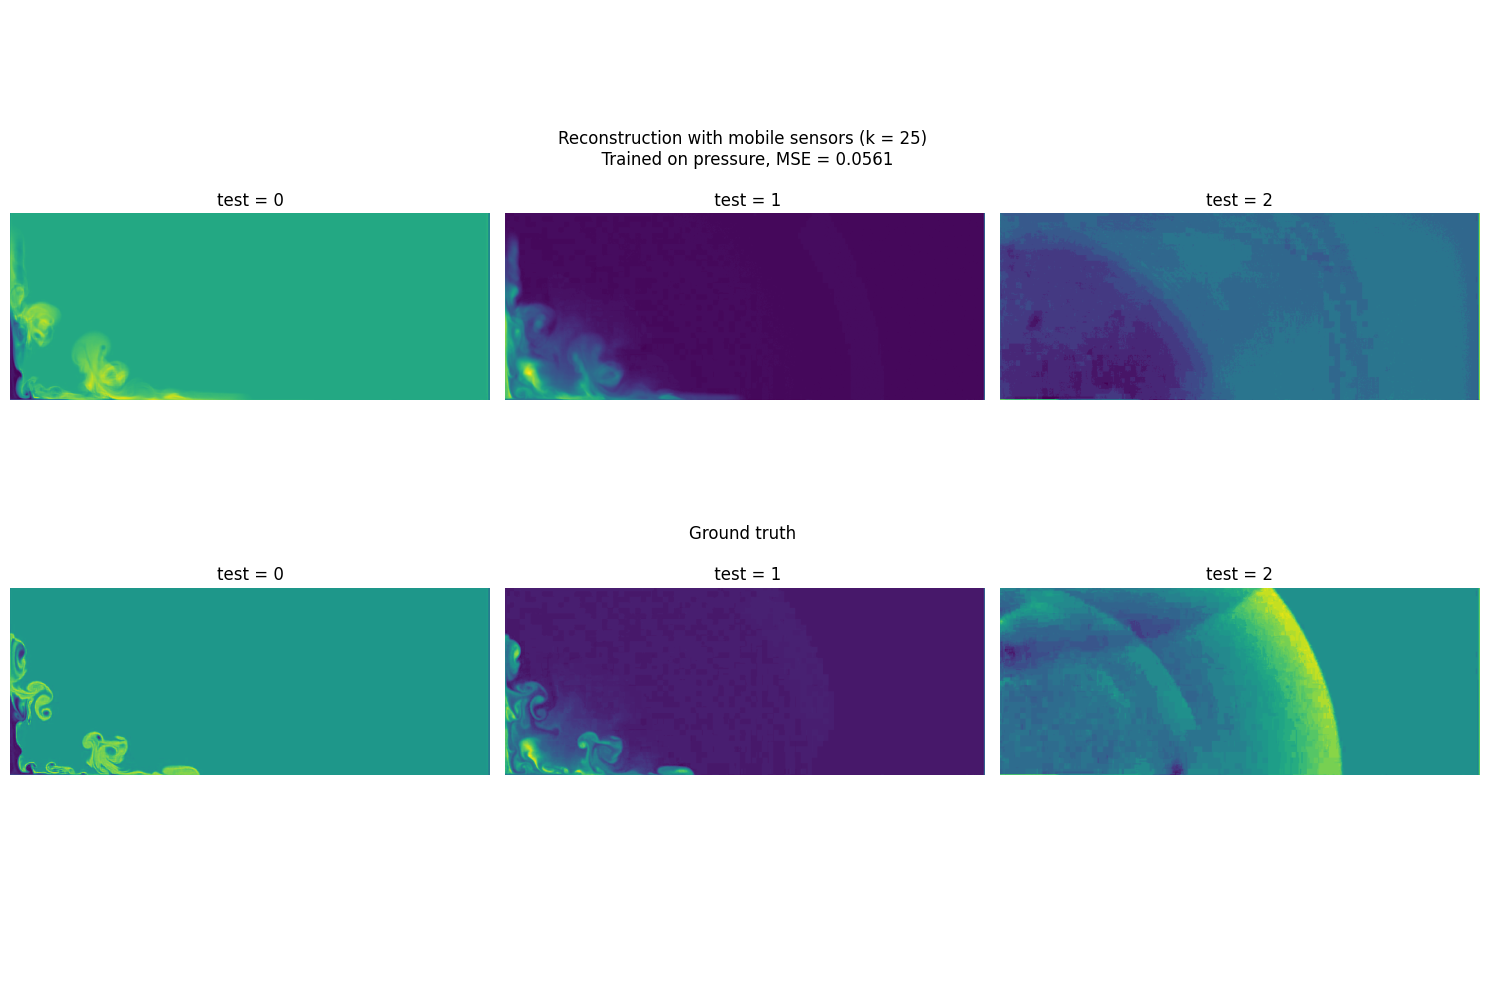

In [409]:
#idx = [1, int(np.round(len(test_recons)/2)), int(len(test_recons))-1]
idx = [0,1,2]

fig = plt.figure(figsize=(15, 10))
plt.axis('off')  # Hide axes
plt.tight_layout()

ax = fig.add_subplot(2, 3, 1)
plt.imshow(np.reshape(test_recons, (-1, row, col, signals))[idx[0]].astype(int))
plt.title('test = {}'.format(idx[0]))
plt.axis('off')  # Hide axes
plt.tight_layout()

ax = fig.add_subplot(2, 3, 4)
plt.imshow(np.reshape(test_ground_truth, (-1, row, col, signals))[idx[0]].astype(int))
plt.title('test = {}'.format(idx[0]))
plt.axis('off')  # Hide axes
plt.tight_layout()

ax = fig.add_subplot(2, 3, 2)
plt.imshow(np.reshape(test_recons, (-1, row, col, signals))[idx[1]].astype(int))
plt.title('Reconstruction with mobile sensors (k = {}) \n  Trained on {}, MSE = {:.4f} \n \n test = {}'.format(lags, data_name, err, idx[1]))
plt.axis('off')  # Hide axes
plt.tight_layout()

ax = fig.add_subplot(2, 3, 5)
plt.imshow(np.reshape(test_ground_truth, (-1, row, col, signals))[idx[1]].astype(int))
plt.title('\n \n \nGround truth \n \n test = {}'.format(idx[1]))
plt.axis('off')  # Hide axes
plt.tight_layout()

ax = fig.add_subplot(2, 3, 3)
plt.imshow(np.reshape(test_recons, (-1, row, col, signals))[idx[2]].astype(int))
plt.title('test = {}'.format(idx[2]))
plt.axis('off')  # Hide axes
plt.tight_layout()

ax = fig.add_subplot(2, 3, 6)
plt.imshow(np.reshape(test_ground_truth, (-1, row, col, signals))[idx[2]].astype(int))
plt.title('test = {}'.format(idx[2]))
plt.axis('off')  # Hide axes
plt.tight_layout()



## SVD rank

In [410]:
X = load_X[train_indices]

rank = int(np.round((lags-1)/2))
print(rank)

U, s, Vh = np.linalg.svd(X, full_matrices=False)
S = np.zeros((rank,rank))
np.fill_diagonal(S, s)

Xr = U[:,0:rank] @ S[0:rank,0:rank] @ Vh[0:rank,:]

calc_MSE(Xr, X)

12


0.051255916047969814